In [4]:
import os
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from datetime import datetime
import matplotlib.colors as mpl
import seaborn as sns
from tqdm import tqdm  
from sklearn.linear_model import Ridge
from scipy.stats import skew
import matplotlib.gridspec as gridspec
import calendar
import scipy.stats as scs
import datetime
from numpy import linspace, meshgrid
from scipy.signal import savgol_filter
from shapely.ops import unary_union
from sklearn.preprocessing import MinMaxScaler

In [9]:
df_nutr = pd.read_csv("/home/jemima/Data/EcoFoodSystems_Dashboard_Development/assets/data/addis_nutrition_outcomes_cleaned.csv")
df_nutr.head(10)

,Cat,Age groups,Outcomes,Reg,Value
0,Percent Distribution of Stunting Among Childre...,CHILDREN,Stunting,Addis Ababa,13.9
1,Percent Distribution of Stunting Among Childre...,CHILDREN,Stunting,National,40.9
2,Percent Distribution of Stunting Among Childre...,CHILDREN,Wasting (%),Addis Ababa,3.8
3,Percent Distribution of Stunting Among Childre...,CHILDREN,Wasting (%),National,11.2
4,Percent Distribution of Stunting Among Childre...,CHILDREN,Underweight (%),Addis Ababa,5.5
5,Percent Distribution of Stunting Among Childre...,CHILDREN,Underweight (%),National,23.3


In [10]:
df_mpi = pd.read_csv("/home/jemima/Data/EcoFoodSystems_Dashboard_Development/assets/data/addis_mpi_long.csv")
df_mpi.head(10)

,Dist_Name,Variable,Value
0,Addis Ketema,Cooking fuel,28.0
1,Addis Ketema,Housing,79.0
2,Addis Ketema,Assets,44.2
3,Addis Ketema,Drinking water,9.8
4,Addis Ketema,Sanitation,85.7
5,Addis Ketema,Electricity,0.0
6,Akaki Kality,Cooking fuel,21.7
7,Akaki Kality,Housing,52.5
8,Akaki Kality,Assets,27.7
9,Akaki Kality,Drinking water,4.5


<Axes: >

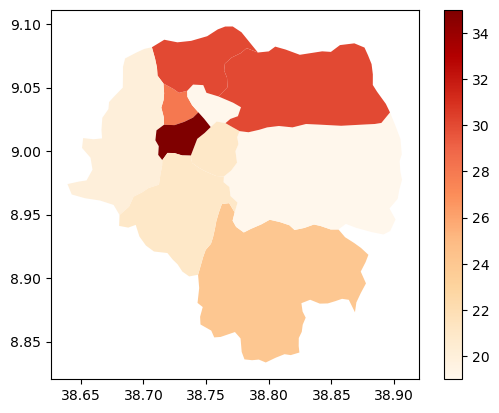

In [13]:
gdf_mpi = gpd.read_file("/home/jemima/Data/EcoFoodSystems_Dashboard_Development/assets/data/addis_adm3_mpi.geojson")
gdf_mpi.plot('MPI', cmap='OrRd', legend=True)

In [26]:
df_foodsec = pd.read_csv("/home/jemima/Data/EcoFoodSystems_Dashboard_Development/assets/data/addis_foodsecurity.csv")
df_foodsec.replace({'Moderat to sever food insecure':'Moderate-Severe Food Insecurity',
                    'Food secure':'Secure',
                    'Mild food insecure':'Mild Food Insecurity  '}, inplace=True)
df_foodsec.head(10)

,Sub City,Food security status,Percentage
0,Addis Ketema,Secure,36.0
1,Addis Ketema,Mild Food Insecurity,25.8
2,Addis Ketema,Moderate-Severe Food Insecurity,38.2
3,Akaki Kality,Secure,18.9
4,Akaki Kality,Mild Food Insecurity,33.1
5,Akaki Kality,Moderate-Severe Food Insecurity,48.0
6,Arada,Secure,54.7
7,Arada,Mild Food Insecurity,24.2
8,Arada,Moderate-Severe Food Insecurity,21.1
9,Bole,Secure,84.7


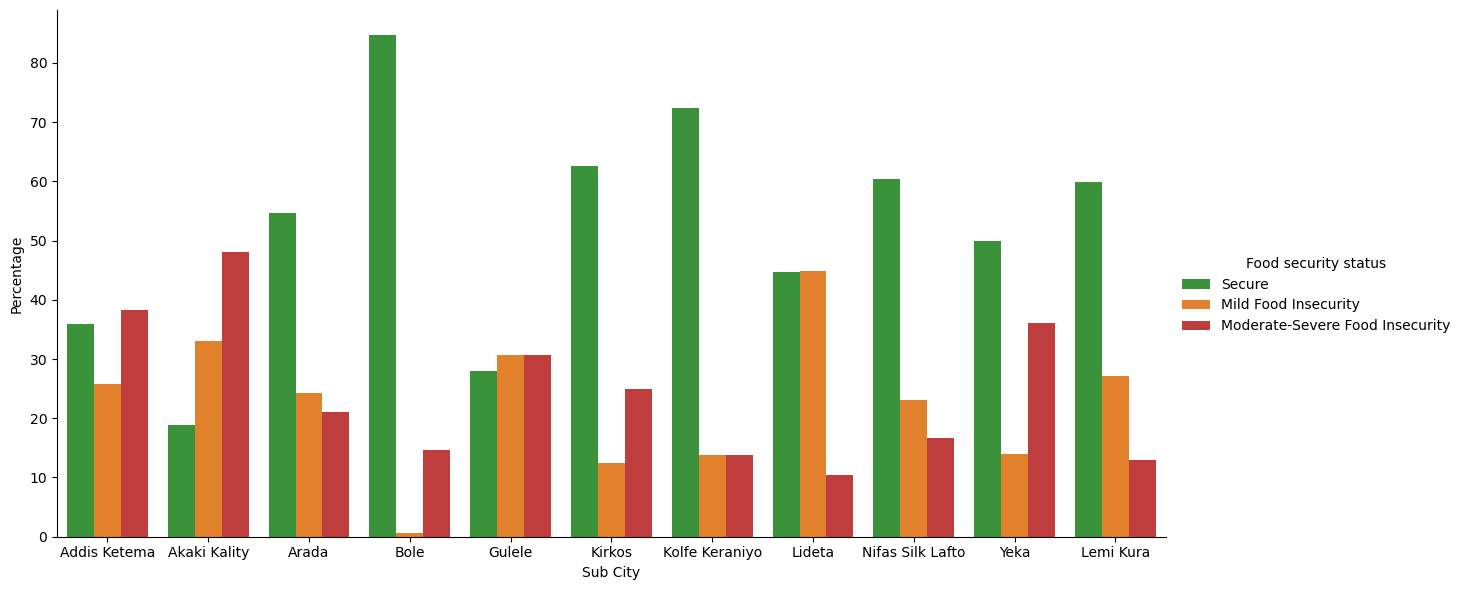

In [27]:
sns.catplot(df_foodsec, kind='bar', x='Sub City', y='Percentage', hue='Food security status', 
            palette=['#2ca02c', '#ff7f0e', '#d62728'],
            height=6, aspect=12/6)

<Axes: >

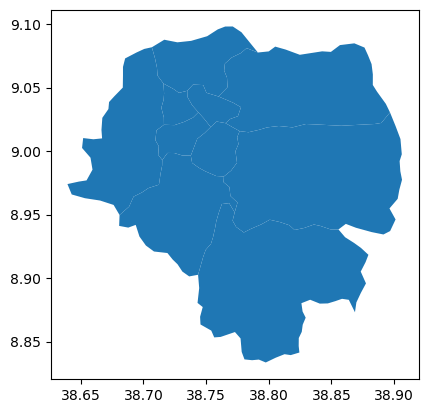

In [95]:
df_foodsec_long = df_foodsec.pivot(index='Sub City', columns='Food security status', values='Percentage')
geos = gdf_mpi[['NAME_3', 'geometry']]
geoseries = gpd.GeoDataFrame(gpd.GeoSeries(geos.set_index('NAME_3')['geometry']).to_crs('EPSG:4326').representative_point())
gdf_foodsec = geoseries.merge(df_foodsec_long, left_on='NAME_3', right_index=True).set_geometry(0)
gdf_foodsec.rename(columns={0: 'geometry'}, inplace=True)
gdf_foodsec = gdf_foodsec[['Secure', 'Mild Food Insecurity  ', 'Moderate-Severe Food Insecurity', 'geometry']]
gdf_foodsec.head(5)

,Secure,Mild Food Insecurity,Moderate-Severe Food Insecurity,geometry
NAME_3,,,,
Addis Ketema,36.0,25.8,38.2,POINT (38.72656 9.03828)
Akaki Kality,18.9,33.1,48.0,POINT (38.80992 8.89919)
Arada,54.7,24.2,21.1,POINT (38.75797 9.03537)
Bole,84.7,0.6,14.7,POINT (38.83602 8.98208)
Gulele,28.0,30.7,30.7,POINT (38.73853 9.07104)


In [96]:
gdf_foodsec.to_file("/home/jemima/Data/EcoFoodSystems_Dashboard_Development/assets/data/addis_food_security.geojson")

<Axes: >

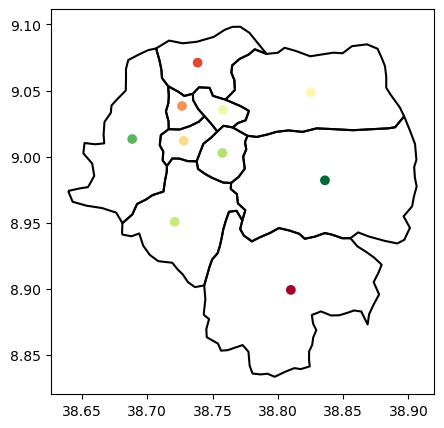

In [89]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
gdf_foodsec.plot('Secure', ax=ax, cmap='RdYlGn')
geos.boundary.plot(ax=ax, color='black')

In [ ]:
def create_pie_chart_icon(values, colors, size=40):
    """
    Create a pie chart as a base64 encoded image for use as a Leaflet marker icon.
    
    Parameters:
    - values: list of values for pie slices
    - colors: list of colors for each slice
    - size: size of the icon in pixels
    """
    fig, ax = plt.subplots(figsize=(size/100, size/100), dpi=100)
    ax.pie(values, colors=colors, startangle=90)
    ax.axis('equal')
    
    # Remove margins
    plt.tight_layout(pad=0)
    
    # Save to buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', transparent=True, bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    plt.close()
    
    # Encode to base64
    img_base64 = base64.b64encode(buf.read()).decode()
    return f"data:image/png;base64,{img_base64}"

In [ ]:
import dash_leaflet as dl
from dash import Dash, html
import dash_bootstrap_components as dbc
import matplotlib.pyplot as plt
import io
import base64
import json

# Create a simple Dash app with Leaflet map
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Create pie chart markers for food security data with tooltips
marker_lst = []
for i in range(gdf_foodsec.shape[0]):
    # Get the subcity name and food security percentages
    subcity_name = gdf_foodsec.index[i]
    secure = gdf_foodsec.iloc[i]['Secure']
    mild = gdf_foodsec.iloc[i]['Mild Food Insecurity  ']
    severe = gdf_foodsec.iloc[i]['Moderate-Severe Food Insecurity']
    
    # Create tooltip content - using simpler text format
    tooltip_content = f"{subcity_name} - \nSecure: {secure:.1f}%\nMild: {mild:.1f}%\nSevere: {severe:.1f}%"
    
    marker = dl.Marker(
        position=[float(x) for x in str(gdf_foodsec.iloc[i].values[-1]).split('POINT (')[1].strip(')').replace(' ', ', ').split(',')][::-1], 
        icon = {
            "iconUrl": create_pie_chart_icon(gdf_foodsec.iloc[i].values[:3], ['#2ca02c', '#ff7f0e', '#d62728'], size=30),
            "iconSize": [30, 30],
            "iconAnchor": [15, 15]  # Center the icon
        },
        children=[
            dl.Tooltip(tooltip_content)
        ]
    )
    marker_lst.append(marker)

# Convert GeoDataFrame boundaries to GeoJSON format
boundaries_geojson = json.loads(geos.to_json())

# Define the layout with different basemap and boundaries
app.layout = html.Div([
    html.H3("Addis Ababa Food Security Dashboard", style={"textAlign": "center"}),
    dl.Map(
        [
            # CartoDB Positron (light clean basemap)
            dl.TileLayer(
                url="https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png",
                attribution='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>'
            ),
            
            # Add GeoJSON boundaries layer
            dl.GeoJSON(
                data=boundaries_geojson,
                style={
                    'color': 'black',
                    'weight': 1,
                    'fillOpacity': 0,  # Transparent fill
                },
                id='boundaries-layer'
            ),
            
            # Add pie chart markers on top
            dl.LayerGroup(marker_lst, id='markers-layer')
        ],
        center=[8.991626, 38.763706],
        zoom=11,
        style={"width": "100%", "height": "90vh"},
    )
])

# Run the app in Jupyter mode
# This will start the server on port 8050 (or next available)
# Access it at http://localhost:8050 in your browser
if __name__ == '__main__':
    app.run(debug=True, jupyter_mode='external', port=8050)

Dash app running on http://127.0.0.1:8050/
